<a href="https://colab.research.google.com/github/A00785001/TC5035/blob/main/002-FeatEng-Image_Branch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ROS Bag Camera Data Extractor & MobileNet V2 Preprocessor
Extract camera images from ROS bags and prepare them for MobileNet V2 feature extraction

### Purpose of This Notebook
This notebook extracts camera images from ROS bag files and prepares them for **MobileNet V2 feature extraction** as part of a sensor fusion pipeline for loop closure detection on a Jetson-based robot.







### What This Notebook Does

**Input:** ROS bag file containing camera images (from topics like `/camera/image_raw` or `/csi_cam_0/image_raw`)

**Processing Steps:**
1. **Extract** images from ROS bag messages
2. **Convert** from ROS image format (bgr8/rgb8/mono8) to RGB numpy arrays
3. **Resize** all images to 224×224 pixels (MobileNet V2 input requirement)
4. **Save** as high-quality JPEGs (quality=95)
5. **Preserve** ROS timestamps for temporal alignment with LiDAR data
6. **Generate** comprehensive metadata (CSV + JSON)




### Why This Preprocessing?

**For Sensor Fusion:**
- **Camera + LiDAR fusion** for robust loop closure detection
- **Temporal alignment** using preserved ROS timestamps
- **Visual features** (from MobileNet V2) + **Geometric features** (from LiDAR 1D CNN)

**224×224 Image Size:**
- ✓ MobileNet V2 requirement (non-negotiable)
- ✓ Standard for ImageNet-pretrained models
- ✓ Good balance: detail vs computational cost
- ✓ Embedded-friendly (Jetbot compatible)

**JPEG Format:**
- ✓ Excellent compression (~45KB per image)
- ✓ Fast to decode
- ✓ Universally supported
- ✓ Quality=95 preserves visual details

**Timestamp Preservation:**
- ✓ Critical for aligning with LiDAR scans
- ✓ Enables temporal synchronization (±50ms typical threshold)
- ✓ Required for sequence-based loop closure
- ✓ Maintains temporal ordering

---

### Pipeline Context

This notebook is **Part 1** of a multi-stage pipeline:

1. **This Notebook** → Extract & preprocess camera images
2. **LiDAR Notebook** → Extract & preprocess LaserScan data
3. **Feature Extraction** → MobileNet V2 (visual) + 1D CNN (geometric)
4. **Sensor Fusion** → Combine features for loop closure detection

---


### Requirements

**Python Packages:**
- `rosbags` - Pure Python ROS bag reader (no ROS installation needed)
- `opencv-python` - Image processing
- `pillow` - Image I/O and resizing
- `numpy` - Array operations
- `matplotlib` - Visualization
- `tqdm` - Progress bars

**Input:**
- ROS bag file with camera topic (bgr8, rgb8, or mono8 encoding)

## Output Structure


**Output:**
- ~45KB per image (JPEG)
- Typical dataset: 1000 images ≈ 45MB

---


### Complete File Structure

After running this notebook, you will have the following directory structure:

```
processed_images/
├── img_00000.jpg              # First processed image
├── img_00001.jpg              # Second processed image
├── img_00002.jpg              # Third processed image
├── img_00003.jpg
├── ...
├── img_NNNNN.jpg              # Last processed image (N = total images - 1)
├── metadata.csv               # Per-image metadata (timestamps, sizes, etc.)
└── dataset_info.json          # Dataset-level metadata and statistics
```

### Image Files (*.jpg)

**Format Specifications:**
- **File format**: JPEG
- **Naming convention**: `img_XXXXX.jpg` (5-digit zero-padded sequential numbering)
- **Image dimensions**: 224 × 224 pixels (exactly)
- **Color channels**: 3 (RGB)
- **Pixel data type**: uint8
- **Pixel value range**: [0, 255]
- **JPEG quality**: 95 (high quality, minimal compression artifacts)
- **Typical file size**: 40-50 KB per image
- **Color space**: RGB (NOT BGR - already converted from ROS)

**Important Notes:**
- Images are **already in RGB** format (converted from ROS bgr8 encoding)
- Images are **resized** from original dimensions to 224×224
- Pixel values are **NOT normalized** - still in [0, 255] range
- **Normalization happens later** during feature extraction

---

### metadata.csv Structure

**Purpose**: Contains per-image metadata for temporal alignment and traceability.

**Format**: CSV with header row

**Columns (8 total):**

| Column Name | Data Type | Example Value | Description | Required for Fusion? |
|-------------|-----------|---------------|-------------|---------------------|
| `filename` | string | `img_00042.jpg` | Image filename in processed_images/ | ✅ Yes |
| `timestamp` | float | `1634567890.123456` | ROS timestamp in seconds (float with microsecond precision) | ✅ Yes (critical!) |
| `timestamp_sec` | integer | `1634567890` | Timestamp seconds part (integer) | ⚠️ Optional |
| `timestamp_nsec` | integer | `123456000` | Timestamp nanoseconds part (0-999999999) | ⚠️ Optional |
| `frame_id` | integer | `42` | Sequential frame number (0-indexed) | ⚠️ Optional |
| `original_width` | integer | `640` | Width of original image from ROS bag (before resize) | ⚠️ Optional |
| `original_height` | integer | `480` | Height of original image from ROS bag (before resize) | ⚠️ Optional |
| `file_size_kb` | float | `45.23` | Size of processed JPEG file in kilobytes | ⚠️ Optional |

**Critical Column Explanations:**

**`timestamp` (Most Important!):**
- **Format**: Floating point seconds since epoch
- **Precision**: Microsecond-level (6 decimal places typical)
- **Purpose**: Enables temporal alignment with LiDAR data
- **Example**: `1634567890.123456` means October 18, 2021, 12:04:50.123456 UTC
- **Usage**: Used to match camera frames with LiDAR scans (±50ms tolerance typical)
- **Source**: Extracted directly from ROS message header

**`timestamp_sec` and `timestamp_nsec`:**
- **Relationship**: `timestamp = timestamp_sec + (timestamp_nsec / 1e9)`
- **Purpose**: Alternative representation for systems that need integer timestamps
- **ROS Standard**: This is how ROS internally stores timestamps
- **Example**: `1634567890` sec + `123456000` nsec = `1634567890.123456` sec

**Sample CSV Content:**
```csv
filename,timestamp,timestamp_sec,timestamp_nsec,frame_id,original_width,original_height,file_size_kb
img_00000.jpg,1634567890.123456,1634567890,123456000,0,640,480,45.23
img_00001.jpg,1634567890.156789,1634567890,156789000,1,640,480,44.87
img_00002.jpg,1634567890.190122,1634567890,190122000,2,640,480,46.01
img_00003.jpg,1634567890.223455,1634567890,223455000,3,640,480,45.67
```

**How to Load in Python:**
```python
import pandas as pd

# Load metadata
metadata = pd.read_csv('processed_images/metadata.csv')

# Access data
print(metadata.head())
print(f"Total images: {len(metadata)}")
print(f"Time span: {metadata['timestamp'].max() - metadata['timestamp'].min():.2f} seconds")

# Get specific image info
img_info = metadata.iloc[0]  # First image
print(f"Filename: {img_info['filename']}")
print(f"Timestamp: {img_info['timestamp']}")
```

---

### dataset_info.json Structure

**Purpose**: Contains dataset-level metadata, processing parameters, and statistics.

**Format**: JSON with nested structure

**Complete Structure with Descriptions:**

```json
{
  "dataset_metadata": {
    "creation_date": "2024-10-23T15:30:45.123456",  // ISO 8601 timestamp of processing
    
    "ros_bag_info": {
      "source_file": "robot_data_2024_10_23.bag",    // Original bag filename
      "bag_duration_sec": 300.5,                       // Total duration in seconds
      "bag_start_time": 1634567890.0,                  // First image timestamp
      "bag_end_time": 1634568190.5                     // Last image timestamp
    },
    
    "camera_info": {
      "topic": "/camera/image_raw",                   // ROS topic name
      "encoding": "bgr8",                              // Original ROS encoding (bgr8, rgb8, mono8, etc.)
      "frame_rate_hz": 29.8,                           // Calculated actual frame rate
      "camera_model": "unknown"                        // Camera model (if available in bag)
    },
    
    "processing_info": {
      "target_size": [224, 224],                       // Output image dimensions [width, height]
      "resize_method": "LANCZOS",                      // PIL resize method used
      "jpeg_quality": 95,                              // JPEG compression quality (0-100)
      "total_images_processed": 1500,                  // Number of successfully processed images
      "processing_script": "rosbag_camera_extractor_v2_rosbags.ipynb"  // Notebook version
    }
  },
  
  "sensor_fusion_notes": {
    "time_synchronization": "ROS timestamps preserved in CSV",  // Temporal alignment method
    "coordinate_frame": "camera_optical_frame",                 // ROS coordinate frame
    "notes": "Images ready for MobileNet V2 feature extraction. Apply preprocess_input() before inference."
  },
  
  "statistics": {
    "fps_actual": 29.8,                                // Calculated frame rate
    "dropped_frames": 5,                               // Number of failed extractions
    "avg_file_size_kb": 45.5,                          // Average JPEG file size
    "total_dataset_size_mb": 68.25                     // Total size of all images
  }
}
```

**Key Field Explanations:**

- **`bag_duration_sec`**: Duration between first and last image (NOT total bag duration)
- **`frame_rate_hz`**: Calculated as: `num_images / bag_duration_sec`
- **`encoding`**: Original ROS image encoding (already converted to RGB in output)
- **`resize_method`**: LANCZOS provides high-quality downsampling
- **`dropped_frames`**: Images that failed to process (corrupted, wrong format, etc.)

**How to Load in Python:**
```python
import json

# Load dataset info
with open('processed_images/dataset_info.json', 'r') as f:
    info = json.load(f)

# Access data
print(f"Total images: {info['dataset_metadata']['processing_info']['total_images_processed']}")
print(f"Frame rate: {info['statistics']['fps_actual']} Hz")
print(f"Dataset size: {info['statistics']['total_dataset_size_mb']} MB")
```

---




### Notes

✅ **Images are NOT normalized here**
- Pixel range stays [0, 255]
- Different models need different preprocessing
- Normalization happens during feature extraction

✅ **Timestamps are critical**
- Used for camera-LiDAR temporal alignment
- Microsecond precision preserved
- Essential for sensor fusion pipeline

---

In [1]:
# Install required packages
!pip install --quiet rosbags opencv-python pillow numpy matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 17.7 MB/s eta 0:00:00


In [2]:
# Import libraries
from rosbags.rosbag1 import Reader
from rosbags.typesys import Stores, get_typestore
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import Path
import json
import csv
from datetime import datetime
from tqdm import tqdm

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [3]:
# Initialize typestore for ROS1 message deserialization
typestore = get_typestore(Stores.ROS1_NOETIC)
print("Typestore initialized for ROS1")


Typestore initialized for ROS1


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
#session = '20251016_133216'
session = '20251022_155137'

print(f"Using session: {session}")

# Specify the path to the ROS bag file within the shared folder
data_path = "/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot"
working_folder = data_path + '/session_' + session
bag_name = 'session_data.bag'

# Change to the specified subfolder
os.chdir(working_folder)
print(f"Changed directory to: {os.getcwd()}")

# Fixed typo: was +_+ now just +
bag_file = working_folder + '/' + bag_name
print(f"Bag file name: {bag_name}")

# Set bag_path for the rest of the notebook
bag_path = bag_file


Using session: 20251022_155137
Changed directory to: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137
Bag file name: session_data.bag


In [6]:
# Read the bag file and list topics
print(f"Opening bag file: {bag_file}")
bag_path = Path(bag_file)

with Reader(bag_path) as reader:
    # Get bag info
    print(f"\nBag duration: {reader.duration / 1e9:.2f} seconds")
    print(f"Start time: {reader.start_time / 1e9:.2f}")
    print(f"Message count: {reader.message_count}")

    # List all topics
    print(f"\nTopics in bag:")
    for connection in reader.connections:
        print(f"  {connection.topic} ({connection.msgtype})")

print(f"\n✓ Bag file opened successfully")

Opening bag file: /content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/session_data.bag

Bag duration: 394.36 seconds
Start time: 1761175573.23
Message count: 158044

Topics in bag:
  /constraint_list (visualization_msgs/msg/MarkerArray)
  /csi_cam_0/camera_info (sensor_msgs/msg/CameraInfo)
  /csi_cam_0/image_raw/compressed (sensor_msgs/msg/CompressedImage)
  /imu (sensor_msgs/msg/Imu)
  /odom (nav_msgs/msg/Odometry)
  /scan (sensor_msgs/msg/LaserScan)
  /submap_list (cartographer_ros_msgs/msg/SubmapList)
  /tf (tf2_msgs/msg/TFMessage)
  /tf (tf2_msgs/msg/TFMessage)
  /tf (tf2_msgs/msg/TFMessage)
  /tf (tf2_msgs/msg/TFMessage)
  /trajectory_node_list (visualization_msgs/msg/MarkerArray)
  /cmd_vel (geometry_msgs/msg/Twist)

✓ Bag file opened successfully


## Section 1: Extract Images from ROS Bag

In [7]:
# Specify the camera topic
camera_topic = '/csi_cam_0/image_raw/compressed'
print(f"Will extract from topic: {camera_topic}")


Will extract from topic: /csi_cam_0/image_raw/compressed


In [8]:
# Create temporary extraction directory
TEMP_EXTRACTION_DIR = "temp_extracted_images"
os.makedirs(TEMP_EXTRACTION_DIR, exist_ok=True)

print(f"Temporary extraction directory: {TEMP_EXTRACTION_DIR}/")

Temporary extraction directory: temp_extracted_images/


In [9]:
# Function to convert ROS Image/CompressedImage message to numpy array
def ros_image_to_numpy(msg, is_compressed=False):
    """
    Convert ROS Image or CompressedImage message to numpy array.

    Args:
        msg: ROS message (Image or CompressedImage)
        is_compressed: True if msg is CompressedImage, False if regular Image

    Returns:
        numpy array in RGB format
    """
    if is_compressed:
        # CompressedImage: decode JPEG/PNG data
        np_arr = np.frombuffer(msg.data, np.uint8)
        img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError("Failed to decode compressed image")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        return img
    else:
        # Regular Image message
        height = msg.height
        width = msg.width
        encoding = msg.encoding

        # Convert bytes to numpy array
        if encoding == 'bgr8':
            img = np.frombuffer(msg.data, dtype=np.uint8).reshape(height, width, 3)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        elif encoding == 'rgb8':
            img = np.frombuffer(msg.data, dtype=np.uint8).reshape(height, width, 3)
        elif encoding == 'mono8':
            img = np.frombuffer(msg.data, dtype=np.uint8).reshape(height, width)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB
        elif encoding == 'bgra8':
            img = np.frombuffer(msg.data, dtype=np.uint8).reshape(height, width, 4)
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        elif encoding == 'rgba8':
            img = np.frombuffer(msg.data, dtype=np.uint8).reshape(height, width, 4)
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        else:
            print(f"Warning: Unsupported encoding {encoding}, attempting bgr8")
            img = np.frombuffer(msg.data, dtype=np.uint8).reshape(height, width, 3)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img

print("Image conversion function ready (supports CompressedImage)")


Image conversion function ready (supports CompressedImage)


In [10]:
# Extract images from bag
print(f"Extracting images from topic: {camera_topic}")

extracted_images = []
image_count = 0

with Reader(bag_path) as reader:
    # Get connections for our topic
    connections = [c for c in reader.connections if c.topic == camera_topic]

    if not connections:
        print(f"ERROR: Topic {camera_topic} not found in bag!")
        print("Available topics:")
        for c in reader.connections:
            print(f"  - {c.topic}")
    else:
        print(f"Found topic: {camera_topic}")
        print(f"Message type: {connections[0].msgtype}")

        # Count messages first for progress bar
        total_messages = sum(1 for _ in reader.messages(connections=connections))
        print(f"Total messages: {total_messages}")

        # Extract images
        for connection, timestamp, rawdata in tqdm(reader.messages(connections=connections),
                                                     total=total_messages,
                                                     desc="Extracting images"):
            # Deserialize message
            msg = typestore.deserialize_ros1(rawdata, connection.msgtype)

            # Check if CompressedImage or regular Image
            is_compressed = 'CompressedImage' in connection.msgtype

            # Convert to numpy image
            try:
                img_array = ros_image_to_numpy(msg, is_compressed=is_compressed)

                # Save temporarily
                img_filename = f"frame_{image_count:06d}.jpg"
                img_path = os.path.join(TEMP_EXTRACTION_DIR, img_filename)

                # Save using PIL
                img_pil = Image.fromarray(img_array)
                img_pil.save(img_path, 'JPEG', quality=95)

                # Store metadata
                extracted_images.append({
                    'filename': img_filename,
                    'timestamp': timestamp / 1e9,  # Convert nanoseconds to seconds
                    'timestamp_nsec': timestamp,
                    'frame_id': image_count,
                    'original_width': img_array.shape[1],
                    'original_height': img_array.shape[0],
                    'encoding': msg.format if is_compressed else getattr(msg, 'encoding', 'unknown')
                })

                image_count += 1

            except Exception as e:
                print(f"\nError processing frame {image_count}: {e}")
                continue

print(f"\n✓ Extracted {image_count} images to {TEMP_EXTRACTION_DIR}/")

Extracting images from topic: /csi_cam_0/image_raw/compressed
Found topic: /csi_cam_0/image_raw/compressed
Message type: sensor_msgs/msg/CompressedImage
Total messages: 7193


Extracting images: 100%|██████████| 7193/7193 [01:52<00:00, 64.20it/s]


✓ Extracted 7193 images to temp_extracted_images/


Displaying sample extracted images...


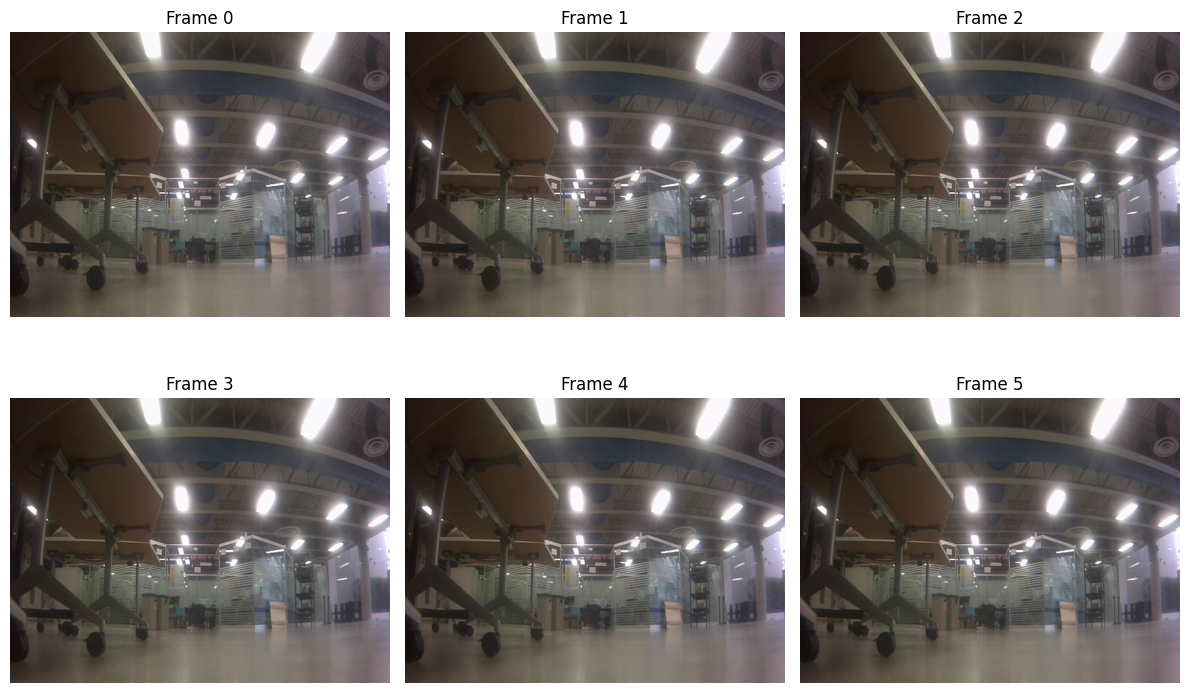


Original image shape: (480, 640, 3)
Total images extracted: 7193


In [11]:
# Display sample extracted images
print(f"Displaying sample extracted images...")

sample_images = []
for i in range(min(6, len(extracted_images))):
    img_path = os.path.join(TEMP_EXTRACTION_DIR, extracted_images[i]['filename'])
    img = Image.open(img_path)
    sample_images.append(np.array(img))

if sample_images:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, img in enumerate(sample_images):
        axes[i].imshow(img)
        axes[i].set_title(f"Frame {i}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nOriginal image shape: {sample_images[0].shape}")
    print(f"Total images extracted: {len(extracted_images)}")

## Section 2: Process Images for MobileNet V2 Feature Extraction

Now that images are extracted, we'll resize them to 224×224 and save as JPEGs with metadata.

**Output:** `processed_images/` folder with resized images, metadata.csv, and dataset_info.json


In [12]:
# MobileNet V2 input parameters
IMG_SIZE = 224
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)
JPEG_QUALITY = 95

print(f"Target image size: {TARGET_SIZE}")
print(f"JPEG quality: {JPEG_QUALITY}")

Target image size: (224, 224)
JPEG quality: 95


In [13]:
# Create output folder structure
OUTPUT_DIR = "processed_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Created output directory: {OUTPUT_DIR}/")
print("Images will be saved with metadata (CSV + JSON)")

Created output directory: processed_images/
Images will be saved with metadata (CSV + JSON)


In [14]:
# Function to preprocess and save images
def preprocess_and_save_image(img_path, save_path, target_size=(224, 224), quality=95):
    """
    Preprocess image for MobileNet V2:
    1. Load image
    2. Resize to 224x224
    3. Save as JPEG

    Returns: (success, original_width, original_height, file_size_kb)
    """
    try:
        # Load image
        img = Image.open(img_path)
        original_size = img.size  # (width, height)

        # Resize to target size
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Save preprocessed image
        img_resized.save(save_path, 'JPEG', quality=quality)

        # Get file size
        file_size_kb = os.path.getsize(save_path) / 1024

        return True, original_size[0], original_size[1], file_size_kb
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return False, 0, 0, 0

print("Preprocessing function ready!")

Preprocessing function ready!


In [15]:
# Process all images and collect metadata
print("Processing images...")

metadata_list = []
total_size_kb = 0
failed_count = 0

for i, img_info in enumerate(tqdm(extracted_images, desc="Processing")):
    # Generate output filename
    output_filename = f"img_{i:05d}.jpg"
    output_path = os.path.join(OUTPUT_DIR, output_filename)

    # Source path
    source_path = os.path.join(TEMP_EXTRACTION_DIR, img_info['filename'])

    # Process and save image
    success, orig_w, orig_h, file_size = preprocess_and_save_image(
        source_path, output_path, TARGET_SIZE, JPEG_QUALITY
    )

    if success:
        # Parse timestamp
        timestamp = img_info['timestamp']
        timestamp_sec = int(timestamp)
        timestamp_nsec = int((timestamp - timestamp_sec) * 1e9)

        # Store metadata
        metadata_list.append({
            'filename': output_filename,
            'timestamp': timestamp,
            'timestamp_sec': timestamp_sec,
            'timestamp_nsec': timestamp_nsec,
            'frame_id': i,
            'original_width': img_info['original_width'],
            'original_height': img_info['original_height'],
            'file_size_kb': round(file_size, 2)
        })

        total_size_kb += file_size
    else:
        failed_count += 1

print(f"\n✓ Completed: {len(metadata_list)} images processed")
print(f"✗ Failed: {failed_count} images")
print(f"Total dataset size: {total_size_kb/1024:.2f} MB")

Processing images...


Processing: 100%|██████████| 7193/7193 [03:13<00:00, 37.14it/s]


✓ Completed: 7193 images processed
✗ Failed: 0 images
Total dataset size: 120.73 MB


In [16]:
# Save CSV metadata (per-image data)
csv_path = os.path.join(OUTPUT_DIR, 'metadata.csv')

with open(csv_path, 'w', newline='') as csvfile:
    fieldnames = ['filename', 'timestamp', 'timestamp_sec', 'timestamp_nsec',
                  'frame_id', 'original_width', 'original_height', 'file_size_kb']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for row in metadata_list:
        writer.writerow(row)

print(f"✓ CSV metadata saved: {csv_path}")

✓ CSV metadata saved: processed_images/metadata.csv


In [17]:
# Calculate statistics
if metadata_list:
    avg_file_size = sum(m['file_size_kb'] for m in metadata_list) / len(metadata_list)

    # Calculate FPS
    if len(metadata_list) > 1:
        time_diff = metadata_list[-1]['timestamp'] - metadata_list[0]['timestamp']
        fps_actual = len(metadata_list) / time_diff if time_diff > 0 else 0
    else:
        fps_actual = 0
        time_diff = 0
else:
    avg_file_size = 0
    fps_actual = 0
    time_diff = 0

In [18]:
# Create JSON metadata (dataset-level info)
json_metadata = {
    "dataset_metadata": {
        "creation_date": datetime.now().isoformat(),
        "ros_bag_info": {
            "source_file": bag_file,
            "bag_duration_sec": time_diff,
            "bag_start_time": metadata_list[0]['timestamp'] if metadata_list else 0,
            "bag_end_time": metadata_list[-1]['timestamp'] if metadata_list else 0
        },
        "camera_info": {
            "topic": camera_topic,
            "encoding": extracted_images[0]['encoding'] if extracted_images else 'unknown',
            "frame_rate_hz": round(fps_actual, 2),
            "camera_model": "unknown"
        },
        "processing_info": {
            "target_size": [IMG_SIZE, IMG_SIZE],
            "resize_method": "LANCZOS",
            "jpeg_quality": JPEG_QUALITY,
            "total_images_processed": len(metadata_list),
            "processing_script": "rosbag_camera_extractor_v2_rosbags.ipynb"
        }
    },
    "sensor_fusion_notes": {
        "time_synchronization": "ROS timestamps preserved in CSV",
        "coordinate_frame": "camera_optical_frame",
        "notes": "Images ready for MobileNet V2 feature extraction. Apply preprocess_input() before inference."
    },
    "statistics": {
        "fps_actual": round(fps_actual, 2),
        "dropped_frames": failed_count,
        "avg_file_size_kb": round(avg_file_size, 2),
        "total_dataset_size_mb": round(total_size_kb / 1024, 2)
    }
}

# Save JSON metadata
json_path = os.path.join(OUTPUT_DIR, 'dataset_info.json')
with open(json_path, 'w') as jsonfile:
    json.dump(json_metadata, jsonfile, indent=2)

print(f"✓ JSON metadata saved: {json_path}")

✓ JSON metadata saved: processed_images/dataset_info.json


In [19]:
# Display summary
print("\n" + "="*50)
print("DATASET PROCESSING COMPLETE")
print("="*50)
print(f"Output directory: {OUTPUT_DIR}/")
print(f"Total images: {len(metadata_list)}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Dataset size: {total_size_kb/1024:.2f} MB")
print(f"Average FPS: {fps_actual:.2f}" if fps_actual > 0 else "FPS: N/A")
print(f"\nMetadata files:")
print(f"  - {csv_path}")
print(f"  - {json_path}")
print("\n" + "="*50)


DATASET PROCESSING COMPLETE
Output directory: processed_images/
Total images: 7193
Image size: 224x224
Dataset size: 120.73 MB
Average FPS: 18.24

Metadata files:
  - processed_images/metadata.csv
  - processed_images/dataset_info.json



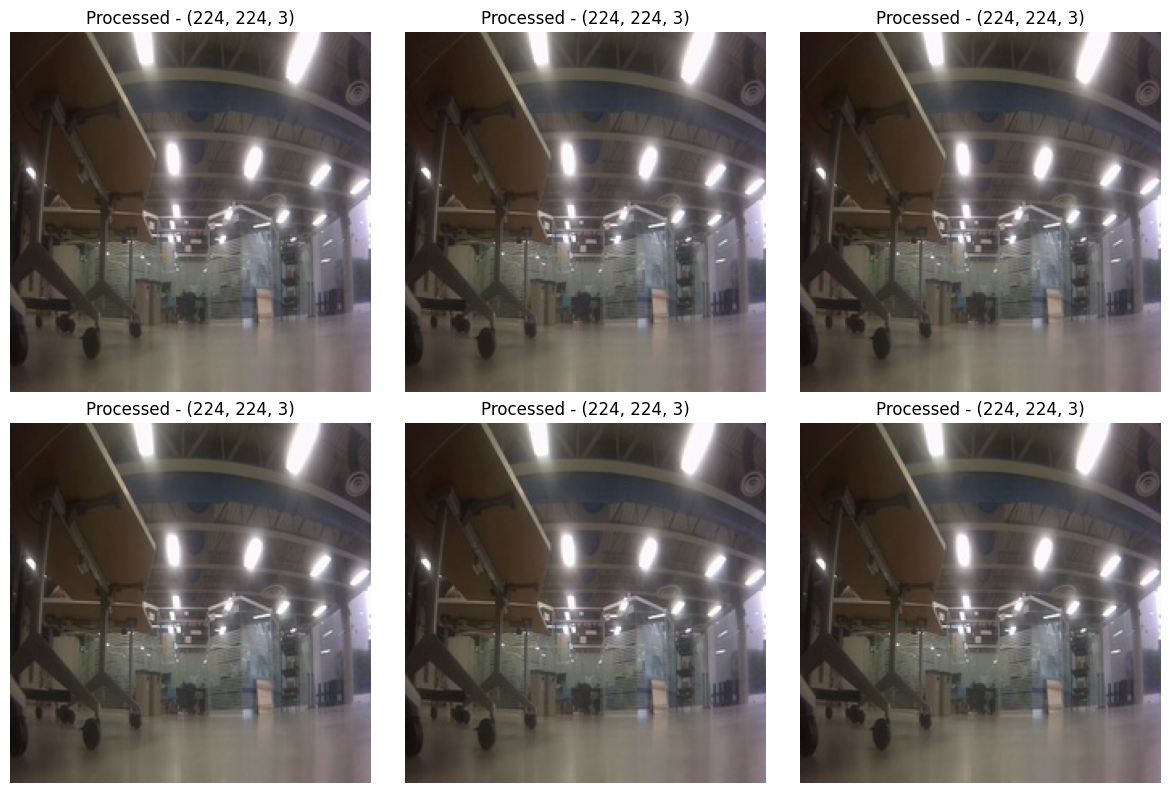

In [20]:
# Display sample processed images
from glob import glob

sample_processed = []
output_images = sorted(glob(os.path.join(OUTPUT_DIR, '*.jpg')))[:6]

for img_path in output_images:
    img = Image.open(img_path)
    sample_processed.append(np.array(img))

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, img in enumerate(sample_processed):
    axes[i].imshow(img)
    axes[i].set_title(f"Processed - {img.shape}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [21]:
# Display actual CSV content (first 10 rows)
import pandas as pd

print("\n" + "="*80)
print("METADATA.CSV CONTENT (First 10 rows)")
print("="*80)

df = pd.read_csv(csv_path)
print(df.head(10).to_string(index=False))

print(f"\n... ({len(df)} total rows)")
print("\n" + "="*80)


METADATA.CSV CONTENT (First 10 rows)
     filename    timestamp  timestamp_sec  timestamp_nsec  frame_id  original_width  original_height  file_size_kb
img_00000.jpg 1.761176e+09     1761175573       225795745         0             640              480         17.86
img_00001.jpg 1.761176e+09     1761175573       225818395         1             640              480         17.89
img_00002.jpg 1.761176e+09     1761175573       225870847         2             640              480         17.83
img_00003.jpg 1.761176e+09     1761175573       225892543         3             640              480         17.91
img_00004.jpg 1.761176e+09     1761175573       225914716         4             640              480         17.87
img_00005.jpg 1.761176e+09     1761175573       225932836         5             640              480         17.84
img_00006.jpg 1.761176e+09     1761175573       225954771         6             640              480         17.86
img_00007.jpg 1.761176e+09     1761175573 

In [22]:
# Display actual JSON content (formatted)
import json

print("\n" + "="*80)
print("DATASET_INFO.JSON CONTENT")
print("="*80)

with open(json_path, 'r') as f:
    json_data = json.load(f)

print(json.dumps(json_data, indent=2))
print("\n" + "="*80)


DATASET_INFO.JSON CONTENT
{
  "dataset_metadata": {
    "creation_date": "2025-11-06T06:18:20.635512",
    "ros_bag_info": {
      "source_file": "/content/drive/MyDrive/DATA/Artificial_Intelligence/MNA-V/Subjects/TC5035-Proyecto_Integrador/TC5035.data/jetbot/session_20251022_155137/session_data.bag",
      "bag_duration_sec": 394.30669021606445,
      "bag_start_time": 1761175573.2257957,
      "bag_end_time": 1761175967.532486
    },
    "camera_info": {
      "topic": "/csi_cam_0/image_raw/compressed",
      "encoding": "rgb8; jpeg compressed bgr8",
      "frame_rate_hz": 18.24,
      "camera_model": "unknown"
    },
    "processing_info": {
      "target_size": [
        224,
        224
      ],
      "resize_method": "LANCZOS",
      "jpeg_quality": 95,
      "total_images_processed": 7193,
      "processing_script": "rosbag_camera_extractor_v2_rosbags.ipynb"
    }
  },
  "sensor_fusion_notes": {
    "time_synchronization": "ROS timestamps preserved in CSV",
    "coordinate_fram

In [23]:
# Generate file tree visualization
print("\n" + "="*80)
print("GENERATED FILE STRUCTURE")
print("="*80)
print(f"\n{OUTPUT_DIR}/")

# Get all files
all_files = sorted(glob(os.path.join(OUTPUT_DIR, '*')))
jpg_files = [f for f in all_files if f.endswith('.jpg')]
csv_files = [f for f in all_files if f.endswith('.csv')]
json_files = [f for f in all_files if f.endswith('.json')]

# Show first few and last few images
if len(jpg_files) > 10:
    display_jpgs = jpg_files[:5] + ['...'] + jpg_files[-5:]
else:
    display_jpgs = jpg_files

for f in display_jpgs:
    if f == '...':
        print(f"├── ...")
        print(f"├── ... ({len(jpg_files) - 10} more images)")
        print(f"├── ...")
    else:
        fname = os.path.basename(f)
        fsize = os.path.getsize(f) / 1024  # KB
        print(f"├── {fname:<20} ({fsize:>6.1f} KB)")

# Show metadata files
for f in csv_files:
    fname = os.path.basename(f)
    fsize = os.path.getsize(f) / 1024
    print(f"├── {fname:<20} ({fsize:>6.1f} KB)")

for f in json_files:
    fname = os.path.basename(f)
    fsize = os.path.getsize(f) / 1024
    print(f"└── {fname:<20} ({fsize:>6.1f} KB)")

print(f"\nTotal: {len(jpg_files)} images + 2 metadata files")
print(f"Total size: {sum(os.path.getsize(f) for f in all_files) / (1024*1024):.2f} MB")
print("\n" + "="*80)


GENERATED FILE STRUCTURE

processed_images/
├── img_00000.jpg        (  17.9 KB)
├── img_00001.jpg        (  17.9 KB)
├── img_00002.jpg        (  17.8 KB)
├── img_00003.jpg        (  17.9 KB)
├── img_00004.jpg        (  17.9 KB)
├── ...
├── ... (7183 more images)
├── ...
├── img_07188.jpg        (  18.9 KB)
├── img_07189.jpg        (  18.9 KB)
├── img_07190.jpg        (  18.9 KB)
├── img_07191.jpg        (  18.9 KB)
├── img_07192.jpg        (  18.9 KB)
├── metadata.csv         ( 515.5 KB)
└── dataset_info.json    (   1.2 KB)

Total: 7193 images + 2 metadata files
Total size: 121.23 MB



In [24]:
# Clean up temporary extraction directory
import shutil

print(f"\nCleaning up temporary files...")
shutil.rmtree(TEMP_EXTRACTION_DIR)
print(f"✓ Removed {TEMP_EXTRACTION_DIR}/")


Cleaning up temporary files...
✓ Removed temp_extracted_images/


### Data Validation Checklist

After processing, verify your dataset:

**File Structure:**
- ✅ `processed_images/` directory exists
- ✅ All images named `img_XXXXX.jpg` with sequential numbering
- ✅ `metadata.csv` exists and has 8 columns
- ✅ `dataset_info.json` exists and is valid JSON

**Image Quality:**
- ✅ All images are exactly 224×224 pixels
- ✅ All images are RGB (3 channels)
- ✅ No corrupted images (can open with PIL)
- ✅ Pixel values in [0, 255] range

**Metadata Integrity:**
- ✅ Number of CSV rows matches number of .jpg files
- ✅ All filenames in CSV exist as files
- ✅ Timestamps are monotonically increasing
- ✅ No duplicate timestamps (or very few)
- ✅ No NaN or missing values in critical columns


In [25]:
# Data validation script
import pandas as pd
from PIL import Image
import os
from glob import glob

print("Running validation checks...\n")

# Check files
images = glob('processed_images/img_*.jpg')
metadata = pd.read_csv('processed_images/metadata.csv')

print(f"✓ Images found: {len(images)}")
print(f"✓ Metadata rows: {len(metadata)}")
assert len(images) == len(metadata), "ERROR: Mismatch between images and metadata!"

# Check first image
img = Image.open('processed_images/img_00000.jpg')
assert img.size == (224, 224), f"ERROR: Wrong size: {img.size}"
assert img.mode == 'RGB', f"ERROR: Wrong mode: {img.mode}"
print(f"✓ Image dimensions correct: {img.size}")
print(f"✓ Image mode correct: {img.mode}")

# Check timestamps
assert metadata['timestamp'].is_monotonic_increasing, "ERROR: Timestamps not in order!"
assert not metadata['timestamp'].isna().any(), "ERROR: Missing timestamps!"
print(f"✓ Timestamps are monotonically increasing")
print(f"✓ No missing timestamps")

print("\n✅ All validation checks passed!")

Running validation checks...

✓ Images found: 7193
✓ Metadata rows: 7193
✓ Image dimensions correct: (224, 224)
✓ Image mode correct: RGB
✓ Timestamps are monotonically increasing
✓ No missing timestamps

✅ All validation checks passed!


## Next Steps

<details>
<summary><b>Click to expand: Feature Extraction with MobileNet V2</b></summary>

Your images are now ready for MobileNet V2 feature extraction. When you're ready to extract features:

```python
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import torch

# Load MobileNet V2 (without top classification layer)
mobilenet = models.mobilenet_v2(pretrained=True)
feature_extractor = torch.nn.Sequential(
    mobilenet.features,
    torch.nn.AdaptiveAvgPool2d((1, 1)),
    torch.nn.Flatten()
)
feature_extractor.eval()

# Load metadata
df = pd.read_csv('processed_images/metadata.csv')

# Preprocessing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Extract features for each image
features_list = []
for idx, row in df.iterrows():
    img_path = f"processed_images/{row['filename']}"
    
    # Load and preprocess
    img = Image.open(img_path)
    img_tensor = preprocess(img).unsqueeze(0)
    
    # Extract features
    with torch.no_grad():
        features = feature_extractor(img_tensor)
    
    features_list.append(features[0].numpy())

# features_list now contains 1280D feature vectors for sensor fusion
```

**Note:** The preprocessing transforms scale pixels to approximately [-1, 1] as required by MobileNet V2.

</details>

<details>
<summary><b>Click to expand: Temporal Alignment Guide</b></summary>

### Using Timestamps for Sensor Fusion

The `timestamp` column in `metadata.csv` is critical for aligning camera and LiDAR data.

**Example Alignment Scenario:**
```
Camera timestamps (30 Hz):  [1.000, 1.033, 1.066, 1.100, 1.133, ...]
LiDAR timestamps  (10 Hz):  [1.000,        1.100,        1.200, ...]
```

**Alignment Strategy:**
1. **Nearest Neighbor**: Match each LiDAR scan to closest camera frame (±50ms typical)
2. **Interpolation**: Create virtual frames between camera captures
3. **Synchronized Only**: Only use frames where both sensors captured within ±10ms

**Python Example for Nearest Neighbor Matching:**

Run this code in a new cell to test temporal alignment:

```python
# Example: Temporal alignment with LiDAR (nearest neighbor)
import pandas as pd
import numpy as np

# This example assumes you have processed_lidar/ from the LiDAR notebook
# Load metadata
try:
    cam_meta = pd.read_csv('processed_images/metadata.csv')
    lid_meta = pd.read_csv('processed_lidar/metadata.csv')

    # Find nearest camera frame for each LiDAR scan
    aligned_pairs = []
    for _, lidar_row in lid_meta.iterrows():
        lidar_time = lidar_row['timestamp']
        
        # Find nearest camera timestamp
        time_diffs = np.abs(cam_meta['timestamp'] - lidar_time)
        nearest_idx = time_diffs.argmin()
        
        # Check if within acceptable threshold (e.g., 50ms)
        if time_diffs.iloc[nearest_idx] < 0.050:  # 50ms threshold
            aligned_pairs.append({
                'camera_file': cam_meta.iloc[nearest_idx]['filename'],
                'lidar_file': lidar_row['filename'],
                'time_diff_ms': time_diffs.iloc[nearest_idx] * 1000
            })

    print(f"Aligned {len(aligned_pairs)} camera-LiDAR pairs")
    if aligned_pairs:
        print(f"Average time difference: {np.mean([p['time_diff_ms'] for p in aligned_pairs]):.2f} ms")

except FileNotFoundError:
    print("LiDAR metadata not found. Run LiDAR preprocessing notebook first.")
```

</details>